Vamos a cargar el archivo de hoja de calculo para revisar el dataset existente

In [3]:
import re

import pytz as tz
from datetime import datetime

import numpy as np
np.random.seed(1337)

import xlrd

import pandas as pd

Activar graficador en linea con parametros predeterminados para los graficos a generarse

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams.update({'font.size': 10})
plt.rcParams['xtick.major.pad']='5'
plt.rcParams['ytick.major.pad']='5'

plt.style.use('ggplot')

In [5]:
import os
import shutil

datadir = '../data'

In [6]:
filename = os.path.join(datadir, 'default of credit card clients.xls')

In [7]:
df = pd.read_excel(filename, header=1)

Revisar las columnas que tiene el archivo, excepto la columna ID que no aporta nada para el modelo

In [8]:
df.columns = [x.lower() for x in df.columns]
df = df.rename(index=str, columns={"pay_0": "pay_1"})
df = df.drop('id', axis=1)
df.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'default payment next month'],
      dtype='object')

Variables:  \
limit_bal cantidad de credito concedido al cliente  \
sex masculino, femenino  \
education 1 = colegio, 2 = universidad, 3 = instituto, 4 = otros  \
marriage 1 = casado, 2 = soltero, 3 = otros  \
age edad en años  \
pay_1 a 6 historial de pagos, cantidad de meses de retraso, valores negativos cantidad de meses que se anticipa, 0 pago el mes que le correponde, valores mayores a cero los meses que se retraso en el pago  \
bill_amt1 a 6 valor a pagar en cada uno de los ultimos meses  \
pay_amt1 a 6 valor pagado en cada uno de los meses  \
default payment next month 0 = pago en el siguiente mes, 1 = no pago en el siguiente mes

In [9]:
print("Numero de variables:  {}".format(len(df.columns)-1))
print("Numero de observaciones: {}".format(df.shape[0]))

df['target'] = df['default payment next month'].astype('category')

# La prediccion se hace sobre la columnas 'target' 1 impago, 0 pago
print("Variable objetivo:       '{}' -> '{}'".format('default payment next month', 'target'))

Numero de variables:  23
Numero de observaciones: 30000
Variable objetivo:       'default payment next month' -> 'target'


In [10]:
pattern = re.compile("^pay_[0-9]+$")
pay_status_columns = [ x for x in df.columns if (pattern.match(x))]

df[pay_status_columns].head(10)

,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6
0,2,2,-1,-1,-2,-2
1,-1,2,0,0,0,2
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,-1,0,-1,0,0,0
5,0,0,0,0,0,0
6,0,0,0,0,0,0
7,0,-1,-1,0,0,-1
8,0,0,2,0,0,0
9,-2,-2,-2,-2,-1,-1


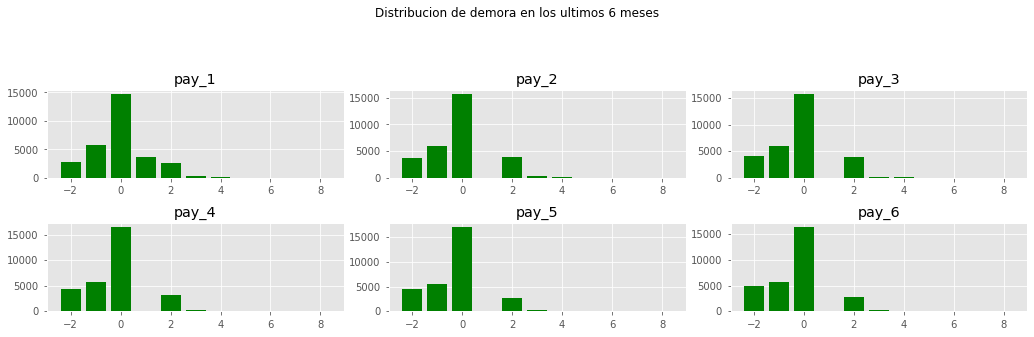

In [11]:
# pay status columns
pattern = re.compile("^pay_[0-9]+$")
pay_status_columns = [ x for x in df.columns if (pattern.match(x))]

fig, ax = plt.subplots(2,3)
fig.set_size_inches(15,5)
fig.suptitle('Distribucion de demora en los ultimos 6 meses')

for i in range(len(pay_status_columns)):
    row,col = int(i/3), i%3

    d  = df[pay_status_columns[i]].value_counts()
    ax[row,col].bar(d.index, d, align='center', color='g')
    ax[row,col].set_title(pay_status_columns[i])

plt.tight_layout(pad=3.0, w_pad=0.5, h_pad=1.0)
plt.show()

Se puede observar que hay varios pagos realizados con dos meses de retraso

Operaciones que caen en impago 22.12% de 30000 observaciones


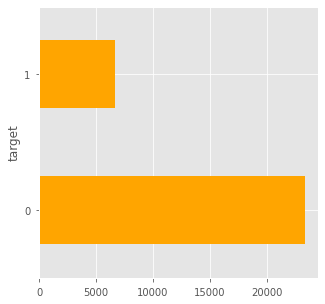

In [12]:
fig = plt.figure()
fig.set_size_inches(5,5)
d = df.groupby(['target']).size()

print("Operaciones que caen en impago {}% de {} observaciones".format(100* d[1]/(d[1]+d[0]), d[1]+d[0]))
p = d.plot(kind='barh', color='orange')

Se procede a etiquetar o categorizar las variables sex, marriage, age

In [13]:
df['sex'] = df['sex'].astype('category').cat.rename_categories(['M', 'F'])
df['marriage'] = df['marriage'].astype('category').cat.rename_categories(['na', 'married', 'single', 'other'])

In [14]:
df['age_cat'] = pd.cut(df['age'], range(0, 100, 5), right=False)

In [15]:
pattern = re.compile("^pay_[0-9]+$")
pay_status_columns = [ x for x in df.columns if (pattern.match(x))]
for i in pay_status_columns:
    df[i] = df[i].astype('category')

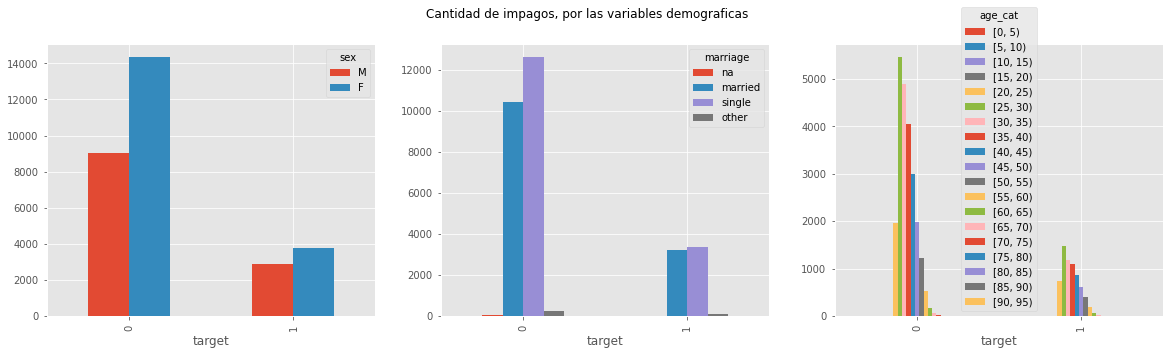

In [16]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(20,5)
fig.suptitle('Cantidad de impagos, por las variables demograficas')

d = df.groupby(['target', 'sex']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[0])

d = df.groupby(['target', 'marriage']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[1])

d = df.groupby(['target', 'age_cat']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[2])

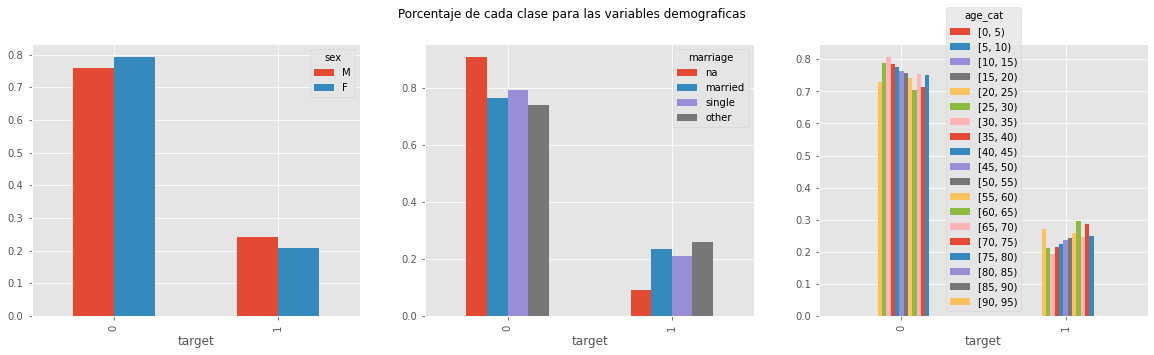

In [17]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(20,5)
fig.suptitle('Porcentaje de cada clase para las variables demograficas')

d = df.groupby(['target', 'sex']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[0])

d = df.groupby(['target', 'marriage']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[1])

d = df.groupby(['target', 'age_cat']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[2])

Para no sesgar a valores de cero y uno, se va a aplicar conversiones logaritmicas

In [18]:
# help func
def selcols(prefix, a=1, b=6):
    return [prefix+str(i) for i in np.arange(a,b+1)]

In [19]:
from math import log

# average and standard deviation payment status
df['pay_avg'] = df[selcols('pay_')].mean(axis=1)
df['pay_std'] = df[selcols('pay_')].std(axis=1)

In [20]:
# average payment
df['pay_amt_avg']     = df[selcols('pay_amt')].mean(axis=1)

# log of average
df['pay_amt_avg_log'] = df['pay_amt_avg'].apply(lambda x: log(x+1))

#amounts relative to the average payment
for i in np.arange(1,7):
    df['pay_relamt'+str(i)] = df['pay_amt'+str(i)]/df['pay_amt_avg']

# log of payments
for i in np.arange(1,7):
    df['pay_amt_log'+str(i)] = df['pay_amt'+str(i)].apply(lambda x: log(x+1))

In [21]:
# average bill
df['bill_amt_avg'] = df[selcols('bill_amt')].mean(axis=1)
df['bill_amt_avg_log'] = df['bill_amt_avg'].apply(lambda x: log(x+1) if x>0 else 0)

# bill sign as a separate feature
for i in np.arange(1,7):
    df['bill_amt_sign'+str(i)] = df['bill_amt'+str(i)].apply(lambda x: float(x>0))
    
# bill log as a separate feature (0 if bill is negative)
for i in np.arange(1,7):
    df['bill_amt_log'+str(i)] = df['bill_amt'+str(i)].apply(lambda x: log(x+1) if x>0 else 0)
    
#bill amounts relative to the limit
for i in np.arange(1,7):
    df['bill_relamt'+str(i)] = df['bill_amt'+str(i)]/df['limit_bal']

In [22]:
#log of credit limit
df['limit_bal_log'] = df['limit_bal'].apply(lambda x: log(x+1))
df['limit_bal_cat'] = pd.cut(df['limit_bal'], range(0, int(1e6), 10000), right=False)

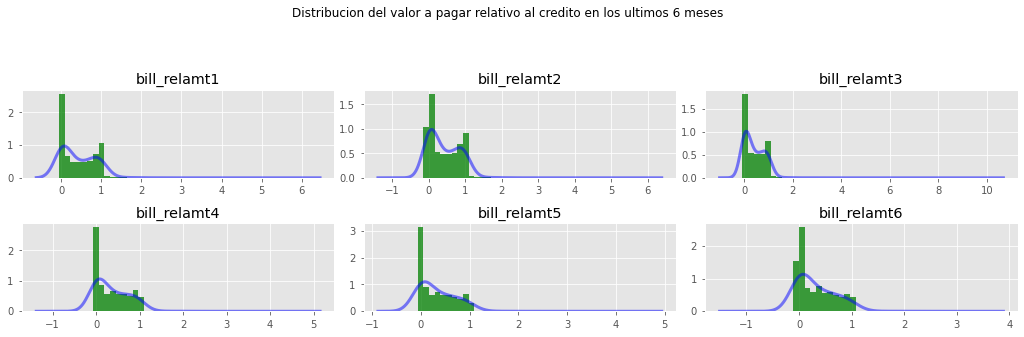

In [54]:
from sklearn.neighbors import KernelDensity

pattern = re.compile("^bill_relamt[0-9]+$")
columns = [ x for x in df.columns if (pattern.match(x))]

fig, ax = plt.subplots(2,3)
fig.set_size_inches(15,5)
fig.suptitle('Distribucion del valor a pagar relativo al credito en los ultimos 6 meses')

for i in range(len(columns)):
    row,col = int(i/3), i%3

    d = df[columns[i]]
    # the histogram of the data
    n, bins, patches = ax[row,col].hist(d, 50, density=1, facecolor='green', alpha=0.75)

    # kernel density estimation
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(d.values.reshape(-1, 1))
    x_grid = np.linspace(d.min(), d.max(), 1000)
    log_pdf = kde.score_samples(x_grid.reshape(-1, 1))

    # add the density line
    ax[row,col].plot(x_grid, np.exp(log_pdf), color='blue', alpha=0.5, lw=3)
    ax[row,col].set_title(columns[i])

plt.tight_layout(pad=3.0, w_pad=0.5, h_pad=1.0)
plt.show()

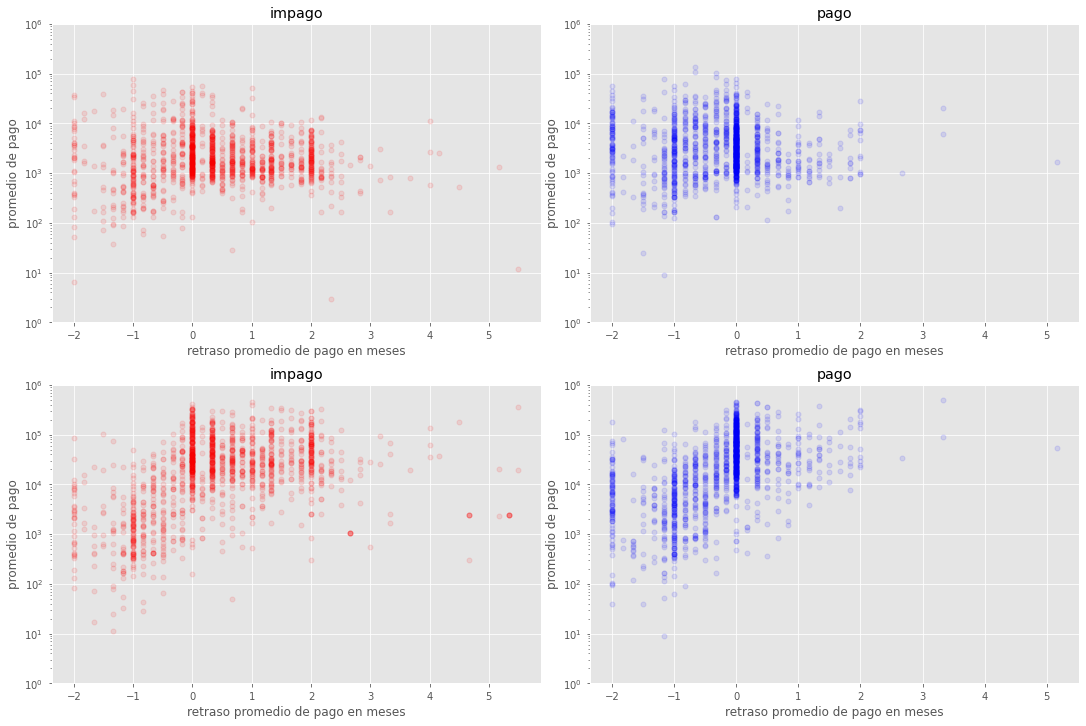

In [25]:
def_no = df[df['target']==0].sample(1500)
def_yes  = df[df['target']==1].sample(1500)

fig,ax = plt.subplots(2,2)
fig.set_size_inches(15,10)

ax[0,0].set_ylim([1,1e6])
ax[0,0].set_title('impago')
ax[0,0].set_ylabel('promedio de pago')
ax[0,0].set_xlabel('retraso promedio de pago en meses')
p = ax[0,0].semilogy(def_yes['pay_avg'], def_yes['pay_amt_avg'], 'ro', markersize=5, alpha=0.1)

ax[0,1].set_ylim([1,1e6])
ax[0,1].set_title('pago')
ax[0,1].set_ylabel('promedio de pago')
ax[0,1].set_xlabel('retraso promedio de pago en meses')
p = ax[0,1].semilogy(def_no['pay_avg'], def_no['pay_amt_avg'], 'bo', markersize=5, alpha=0.1)

ax[1,0].set_ylim([1,1e6])
ax[1,0].set_title('impago')
ax[1,0].set_ylabel('promedio de pago')
ax[1,0].set_xlabel('retraso promedio de pago en meses')
p = ax[1,0].semilogy(def_yes['pay_avg'], def_yes['bill_amt_avg'], 'ro', markersize=5, alpha=0.1)

ax[1,1].set_ylim([1,1e6])
ax[1,1].set_title('pago')
ax[1,1].set_ylabel('promedio de pago')
ax[1,1].set_xlabel('retraso promedio de pago en meses')
p = ax[1,1].semilogy(def_no['pay_avg'], def_no['bill_amt_avg'], 'bo', markersize=5, alpha=0.1)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

Separar en matrices las variables para entrenamiento y test

In [34]:
from patsy import dmatrices

formula  = 'target ~ '

# original features
formula += 'C(sex) + C(marriage) +  C(education) + age'
formula += '+' + '+'.join(selcols('pay_'))

#### engineered / normalized features

# categorical age and credit limit (binned)
formula += '+' + 'C(age_cat)'
formula += '+' + 'C(limit_bal_cat) + limit_bal_log'

#pay delays
formula += '+' + 'pay_avg + pay_std'
    
#pay_amt
formula += '+' + 'pay_amt_avg_log'
formula += '+' + '+'.join(selcols('pay_relamt'))
formula += '+' + '+'.join(selcols('pay_amt_log'))

# bill amounts
formula += '+' + 'bill_amt_avg_log'
formula += '+' + '+'.join(selcols('bill_relamt'))
formula += '+' + '+'.join(selcols('bill_amt_sign'))
formula += '+' + '+'.join(selcols('bill_amt_log'))

y, X = dmatrices(formula, data=df, return_type='dataframe')
y = y.iloc[:, 1]

Funciones para visualizacion matrices de confunsion y metrica AUC

In [35]:
import itertools
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix

def plot_cm(ax, y_true, y_pred, classes, title, th=0.5, cmap=plt.cm.Blues):
    y_pred_labels = (y_pred>th).astype(int)
    
    cm = confusion_matrix(y_true, y_pred_labels)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

def plot_auc(ax, y_train, y_train_pred, y_test, y_test_pred, th=0.5):

    y_train_pred_labels = (y_train_pred>th).astype(int)
    y_test_pred_labels  = (y_test_pred>th).astype(int)

    fpr_train, tpr_train, _ = roc_curve(y_train,y_train_pred)
    roc_auc_train = auc(fpr_train, tpr_train)
    acc_train = accuracy_score(y_train, y_train_pred_labels)

    fpr_test, tpr_test, _ = roc_curve(y_test,y_test_pred)
    roc_auc_test = auc(fpr_test, tpr_test)
    acc_test = accuracy_score(y_test, y_test_pred_labels)

    ax.plot(fpr_train, tpr_train)
    ax.plot(fpr_test, tpr_test)

    ax.plot([0, 1], [0, 1], 'k--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    
    train_text = 'train acc = {:.3f}, auc = {:.2f}'.format(acc_train, roc_auc_train)
    test_text = 'test acc = {:.3f}, auc = {:.2f}'.format(acc_test, roc_auc_test)
    ax.legend([train_text, test_text])

Seleccion de caracteristica

In [38]:
import warnings
from sklearn.feature_selection import SelectKBest, f_classif

warnings.simplefilter(action='ignore', category=(UserWarning,RuntimeWarning))

selector = SelectKBest(f_classif)
selector.fit(X, y)

SelectKBest()

In [39]:
top_indices = np.nan_to_num(selector.scores_).argsort()[-25:][::-1]
selector.scores_[top_indices]
X.columns[top_indices]

Index(['pay_1[T.2]', 'pay_2[T.2]', 'pay_avg', 'pay_3[T.2]', 'pay_4[T.2]',
       'pay_5[T.2]', 'pay_std', 'pay_6[T.2]', 'pay_1[T.0]', 'limit_bal_log',
       'pay_amt_log1', 'pay_amt_avg_log', 'bill_relamt6', 'pay_2[T.0]',
       'bill_relamt5', 'bill_relamt4', 'pay_amt_log2', 'bill_relamt3',
       'bill_relamt2', 'pay_amt_log3', 'pay_1[T.3]', 'bill_relamt1',
       'pay_2[T.3]', 'pay_3[T.0]', 'pay_amt_log4'],
      dtype='object')

Parece que algunas de las funciones construidas son realmente beneficiosas. Además, parece que las variables demograficas solo influyen marginalmente en la predicción, los montos pagados, los retrasos y el valor a pagar en relación con el crédito emitido son los principales indicadores

Escalando caracteristicas

In [40]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
scaler.fit(X)

MinMaxScaler()

In [41]:
from sklearn.pipeline import Pipeline

preprocess = Pipeline([('anova', selector), ('scale', scaler)])
preprocess.fit(X,y)

X_prep = preprocess.transform(X)

Seleccion de modelos y validacion

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_prep, y, test_size=0.2, random_state=42)

Aplicacion de modelos

Regresion logistica

In [45]:
from sklearn import linear_model

# Create logistic regression object
regr = linear_model.LogisticRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

LogisticRegression()

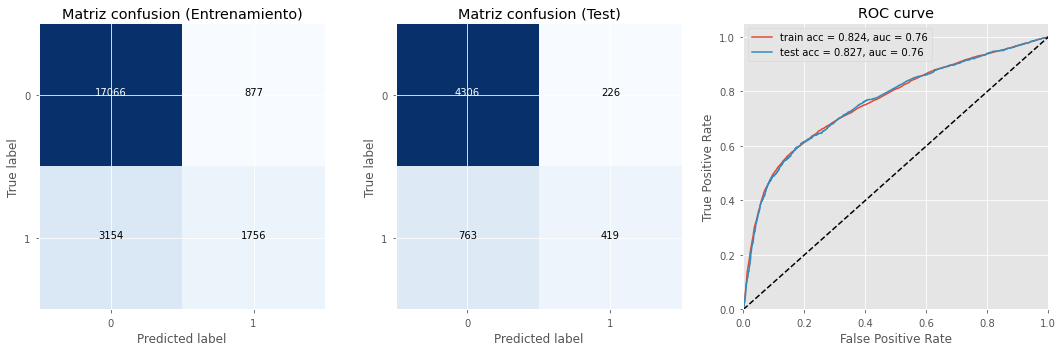

In [46]:
y_train_pred = regr.predict_proba(X_train)[:,1]
y_test_pred = regr.predict_proba(X_test)[:,1]

threshold = 0.5

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Matriz confusion (Entrenamiento)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Matriz confusion (Test)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500, min_samples_leaf=5)
rf.fit(X_train,y_train)

RandomForestClassifier(min_samples_leaf=5, n_estimators=500)

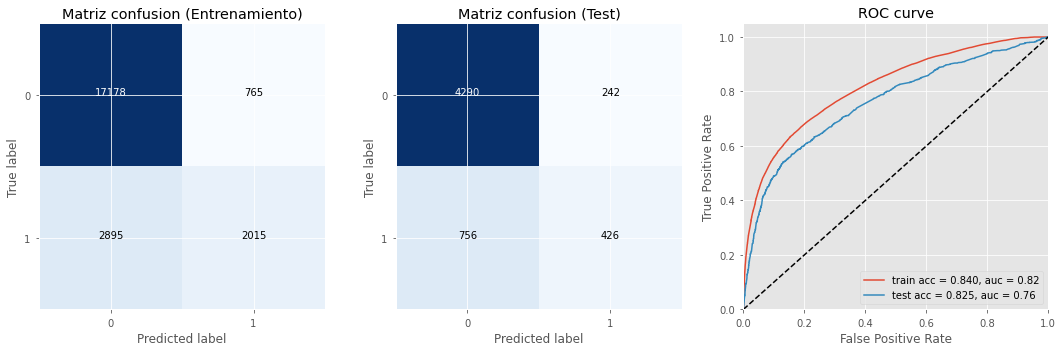

In [48]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score

threshold = 0.5
y_train_pred = rf.predict_proba(X_train)[:,1]
y_test_pred = rf.predict_proba(X_test)[:,1]

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Matriz confusion (Entrenamiento)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Matriz confusion (Test)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

Decision Trees boosting

In [49]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

num_round = 5
evallist  = [(dtest,'eval'), (dtrain,'train')]
param = {'objective':'binary:logistic', 'silent':1, 'eval_metric': ['error', 'logloss']}

bst = xgb.train( param, dtrain, num_round, evallist )

[03:34:16] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	eval-error:0.17343	eval-logloss:0.57271	train-error:0.17087	train-logloss:0.57147
[1]	eval-error:0.17361	eval-logloss:0.50906	train-error:0.16974	train-logloss:0.50673
[2]	eval-error:0.17291	eval-logloss:0.47249	train-error:0.16926	train-logloss:0.46985
[3]	eval-error:0.17221	eval-logloss:0.45131	train-error:0.16899	train-logloss:0.44795
[4]	eval-error:0.17133	eval-logloss:0.43884	train-error:0.16803	train-logloss:0.43476


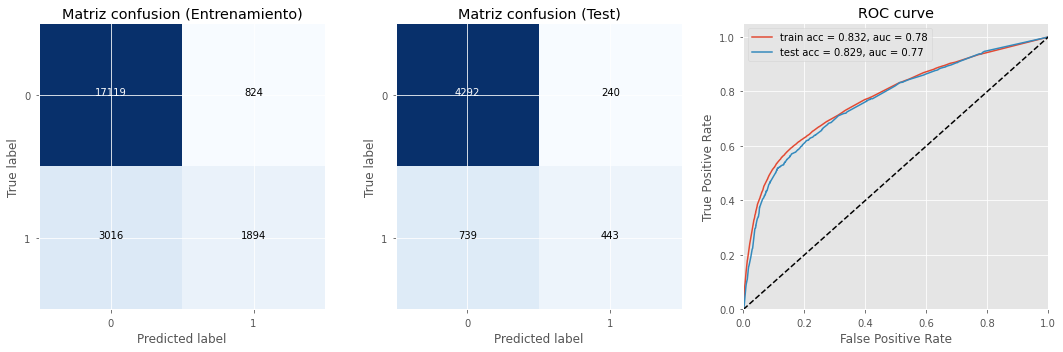

In [51]:
threshold = 0.5
y_train_pred = bst.predict(dtrain)
y_test_pred = bst.predict(dtest)

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Matriz confusion (Entrenamiento)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Matriz confusion (Test)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()